In [1]:
import gzip

import numpy as np
import scipy
import scipy.signal

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style="white", palette="muted")
%matplotlib inline

In [ ]:
# run cell for interactive plots
import mpld3
mpld3.enable_notebook()

In [2]:
def load_log(filename):
    """Load data from logs generated from limtoc. Returns
    a numpy record array.
    """
    datatype = None
    values = []
    
    if filename.endswith('.gz'):
        openf = lambda x: gzip.open(x, 'rt')
    else:
        openf = open
    
    with openf(filename) as f:
        for line in f:
            if not line.strip():
                continue
            if datatype is None:
                if line.strip().endswith('fields are:'):
                    # ignore lines until we get here
                    # next line describes data
                    datatype = []
                elif 'k = ' in line:
                    print(line.strip())
                continue
            if not datatype:
                field_names = line.split(',')
                datatype = np.dtype(
                    [('time', '<f8')] + [(name.strip(), '<f8') for name in field_names])
            else:
                vals = [float(f) for f in line.split(',')]
                assert len(vals) == len(datatype) - 1
                vals.insert(0, vals[0]) # copy clock field value to time
                values.append(tuple(vals))
                
    data = np.rec.array(values, dtype=datatype)
    t = data.time
    dt = np.diff(t)
    overflow_counts = 2**32 * np.cumsum(dt < 0)
    data.time[1:] += overflow_counts
    data.time -= data.time[0]
    data.time /= 168e6 # real time clock frequency
    return data

In [3]:
def plot_log(record, show_plot=True):
    colors = sns.color_palette('Paired', 10)
    fig, ax = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
    
    ax[0].plot(record.time, record.steer_angle, color=colors[1], label='steer angle')
    ax[0].plot(record.time, 0*record.time, color='black', linewidth=1, zorder=1)
    ax[0].legend()
    ax[0].set_xlabel('time [s]')
    ax[0].set_ylabel('[rad]')
    
    ax[1].plot(record.time, record.kistler_torque, color=colors[3],
               alpha=0.8, label='sensor torque')
    ax[1].plot(record.time, record.motor_torque, color=colors[5],
               alpha=0.8, label='motor torque')
    ax[1].plot(record.time, record.feedback_torque, color=colors[7],
               alpha=0.8, label='feedback torque command')
    ax[1].legend()
    ax[1].set_xlabel('time [s]')
    ax[1].set_ylabel('torque [N-m]')
    ax[1].plot(record.time, 0*record.time, color='black', linewidth=1, zorder=1)
    if show_plot:
        plt.show()
    return fig, ax

In [4]:
def display_log_plot(filename):
    vals = load_log(filename)
    fig, ax = plot_log(vals, show_plot=False)
    try:
        title = filename
        mpld3
    except NameError:
        fig.suptitle(title)
    else:
        ax[0].set_title(title)
    plt.show()

running limtoc 626a9c2, k =    3.140


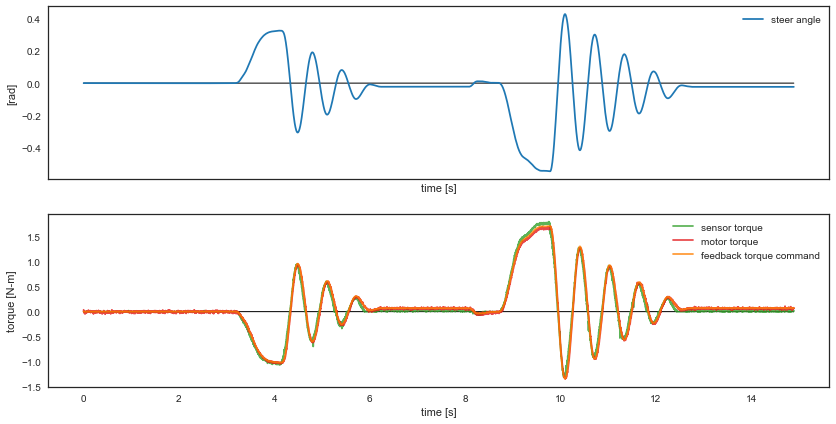

(<matplotlib.figure.Figure at 0x116227198>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1162279b0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1165204a8>], dtype=object))

In [5]:
data = load_log('torque_oscillation.log.gz')
plot_log(data)